In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)



train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


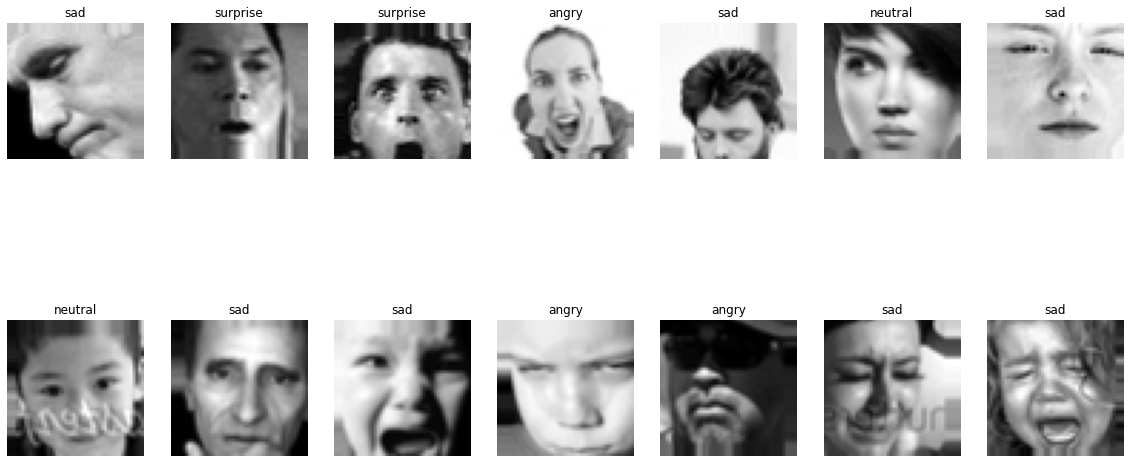

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def model_five(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [20]:
model = model_five(shape = (48, 48, 1), classes = 7)

epochs = 200
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_18 (BatchN  (None, 7, 7, 128)   512         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
          

 conv2d_29 (Conv2D)             (None, 4, 4, 256)    590080      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_27 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalizat

                                                                  'activation_34[0][0]']          
                                                                                                  
 activation_36 (Activation)     (None, 4, 4, 256)    0           ['add_17[0][0]']                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
          

 activation_45 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_45[0][0]']          
                                                                                                  
 batch_normalization_46 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_6[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_55 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 2, 2, 512)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
          

In [21]:
learning_rate = 0.001
decay_rate = learning_rate / 25
# momentum = 0.8
opt = Adam(lr=learning_rate,  decay=decay_rate)


model.compile(
    optimizer = opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    'fer-4422.h5', 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [23]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator,callbacks=[checkpoint])

Epoch 1/200
359/359 [==============================] - ETA: 0s - loss: 2.1596 - accuracy: 0.2306
Epoch 1: val_accuracy improved from -inf to 0.17179, saving model to fer-4422.h5
359/359 [==============================] - 142s 363ms/step - loss: 2.1596 - accuracy: 0.2306 - val_loss: 1.8864 - val_accuracy: 0.1718
Epoch 2/200
359/359 [==============================] - ETA: 0s - loss: 1.7825 - accuracy: 0.2556
Epoch 2: val_accuracy improved from 0.17179 to 0.24860, saving model to fer-4422.h5
359/359 [==============================] - 130s 363ms/step - loss: 1.7825 - accuracy: 0.2556 - val_loss: 1.8359 - val_accuracy: 0.2486
Epoch 3/200
359/359 [==============================] - ETA: 0s - loss: 1.7444 - accuracy: 0.2850
Epoch 3: val_accuracy improved from 0.24860 to 0.29469, saving model to fer-4422.h5
359/359 [==============================] - 120s 333ms/step - loss: 1.7444 - accuracy: 0.2850 - val_loss: 1.7414 - val_accuracy: 0.2947
Epoch 4/200
359/359 [==============================] - 

359/359 [==============================] - ETA: 0s - loss: 1.0657 - accuracy: 0.6067
Epoch 28: val_accuracy improved from 0.55656 to 0.57542, saving model to fer-4422.h5
359/359 [==============================] - 125s 348ms/step - loss: 1.0657 - accuracy: 0.6067 - val_loss: 1.1193 - val_accuracy: 0.5754
Epoch 29/200
359/359 [==============================] - ETA: 0s - loss: 1.0552 - accuracy: 0.6070
Epoch 29: val_accuracy did not improve from 0.57542
359/359 [==============================] - 117s 325ms/step - loss: 1.0552 - accuracy: 0.6070 - val_loss: 1.1174 - val_accuracy: 0.5726
Epoch 30/200
359/359 [==============================] - ETA: 0s - loss: 1.0420 - accuracy: 0.6134
Epoch 30: val_accuracy did not improve from 0.57542
359/359 [==============================] - 118s 328ms/step - loss: 1.0420 - accuracy: 0.6134 - val_loss: 1.1588 - val_accuracy: 0.5468
Epoch 31/200
359/359 [==============================] - ETA: 0s - loss: 1.0277 - accuracy: 0.6178
Epoch 31: val_accuracy impr

Epoch 56/200
359/359 [==============================] - ETA: 0s - loss: 0.7691 - accuracy: 0.7190
Epoch 56: val_accuracy did not improve from 0.62430
359/359 [==============================] - 117s 325ms/step - loss: 0.7691 - accuracy: 0.7190 - val_loss: 1.0829 - val_accuracy: 0.5978
Epoch 57/200
359/359 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.7254
Epoch 57: val_accuracy did not improve from 0.62430
359/359 [==============================] - 117s 325ms/step - loss: 0.7594 - accuracy: 0.7254 - val_loss: 1.0500 - val_accuracy: 0.6208
Epoch 58/200
359/359 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.7233
Epoch 58: val_accuracy did not improve from 0.62430
359/359 [==============================] - 117s 326ms/step - loss: 0.7508 - accuracy: 0.7233 - val_loss: 1.0825 - val_accuracy: 0.6110
Epoch 59/200
359/359 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.7307
Epoch 59: val_accuracy improved from 0.62430 to

359/359 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7917
Epoch 84: val_accuracy did not improve from 0.65154
359/359 [==============================] - 116s 322ms/step - loss: 0.5795 - accuracy: 0.7917 - val_loss: 1.0761 - val_accuracy: 0.6250
Epoch 85/200
359/359 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7965
Epoch 85: val_accuracy did not improve from 0.65154
359/359 [==============================] - 116s 322ms/step - loss: 0.5653 - accuracy: 0.7965 - val_loss: 1.1137 - val_accuracy: 0.6138
Epoch 86/200
359/359 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.7987
Epoch 86: val_accuracy did not improve from 0.65154
359/359 [==============================] - 115s 321ms/step - loss: 0.5619 - accuracy: 0.7987 - val_loss: 1.0667 - val_accuracy: 0.6376
Epoch 87/200
359/359 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.7981
Epoch 87: val_accuracy did not improve from 0.65154
359/359 

Epoch 113/200
359/359 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8422
Epoch 113: val_accuracy did not improve from 0.65154
359/359 [==============================] - 115s 320ms/step - loss: 0.4397 - accuracy: 0.8422 - val_loss: 1.3348 - val_accuracy: 0.5747
Epoch 114/200
359/359 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8477
Epoch 114: val_accuracy improved from 0.65154 to 0.65573, saving model to fer-4422.h5
359/359 [==============================] - 123s 343ms/step - loss: 0.4294 - accuracy: 0.8477 - val_loss: 1.1459 - val_accuracy: 0.6557
Epoch 115/200
359/359 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8464
Epoch 115: val_accuracy did not improve from 0.65573
359/359 [==============================] - 114s 317ms/step - loss: 0.4340 - accuracy: 0.8464 - val_loss: 1.1647 - val_accuracy: 0.6145
Epoch 116/200
359/359 [==============================] - ETA: 0s - loss: 0.4286 - accuracy: 0.8463
Epoch 1

359/359 [==============================] - 115s 321ms/step - loss: 0.3455 - accuracy: 0.8765 - val_loss: 1.2066 - val_accuracy: 0.6404
Epoch 142/200
359/359 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8792
Epoch 142: val_accuracy did not improve from 0.65573
359/359 [==============================] - 115s 321ms/step - loss: 0.3439 - accuracy: 0.8792 - val_loss: 1.2084 - val_accuracy: 0.6341
Epoch 143/200
359/359 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8824
Epoch 143: val_accuracy did not improve from 0.65573
359/359 [==============================] - 115s 320ms/step - loss: 0.3370 - accuracy: 0.8824 - val_loss: 1.1955 - val_accuracy: 0.6222
Epoch 144/200
359/359 [==============================] - ETA: 0s - loss: 0.3403 - accuracy: 0.8792
Epoch 144: val_accuracy did not improve from 0.65573
359/359 [==============================] - 115s 320ms/step - loss: 0.3403 - accuracy: 0.8792 - val_loss: 1.2246 - val_accuracy: 0.6320
Epoc

359/359 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.8989
Epoch 170: val_accuracy did not improve from 0.65573
359/359 [==============================] - 114s 319ms/step - loss: 0.2810 - accuracy: 0.8989 - val_loss: 1.3299 - val_accuracy: 0.6096
Epoch 171/200
359/359 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.9028
Epoch 171: val_accuracy did not improve from 0.65573
359/359 [==============================] - 115s 320ms/step - loss: 0.2766 - accuracy: 0.9028 - val_loss: 1.3171 - val_accuracy: 0.6292
Epoch 172/200
359/359 [==============================] - ETA: 0s - loss: 0.2710 - accuracy: 0.9041
Epoch 172: val_accuracy did not improve from 0.65573
359/359 [==============================] - 115s 320ms/step - loss: 0.2710 - accuracy: 0.9041 - val_loss: 1.3334 - val_accuracy: 0.6292
Epoch 173/200
359/359 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.9057
Epoch 173: val_accuracy did not improve from 0.65573
3

359/359 [==============================] - 115s 319ms/step - loss: 0.2295 - accuracy: 0.9197 - val_loss: 1.3655 - val_accuracy: 0.6348
Epoch 199/200
359/359 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9194
Epoch 199: val_accuracy did not improve from 0.65712
359/359 [==============================] - 115s 320ms/step - loss: 0.2279 - accuracy: 0.9194 - val_loss: 1.3279 - val_accuracy: 0.6362
Epoch 200/200
359/359 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9201
Epoch 200: val_accuracy did not improve from 0.65712
359/359 [==============================] - 115s 320ms/step - loss: 0.2281 - accuracy: 0.9201 - val_loss: 1.3141 - val_accuracy: 0.6418


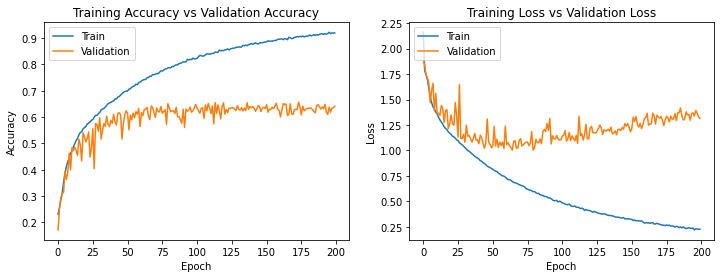

In [24]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [25]:
model.save('deeperdropout4422_200_model.h5')
model.save_weights('deeperdropout4422_200_weights.h5')

In [26]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 2s 85ms/step - loss: 1.3141 - accuracy: 0.6418
final train accuracy = 91.82 , validation accuracy = 64.18


In [29]:
model = tf.keras.models.load_model('fer-4422.h5')

In [30]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 3s 130ms/step - loss: 1.2438 - accuracy: 0.6571
final train accuracy = 92.23 , validation accuracy = 65.71


In [31]:
train_generator.reset()
X_train, y_train = next(train_generator)
for i in range(int(len(train_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(train_generator)
    X_train = np.append(X_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

validation_generator.reset()
X_test, y_test = next(validation_generator)
for i in range(int(len(validation_generator))-1): #1st batch is already fetched before the for loop.
    img, label = next(validation_generator)
    X_test = np.append(X_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

(22968, 48, 48, 1) (22968, 7)
(1432, 48, 48, 1) (1432, 7)


In [32]:
ypred = model.predict(X_train)
ypred = ypred.argmax(axis=-1)


ytrain = y_train.argmax(axis=-1)

ypred_test = model.predict(X_test)
ypred_test = ypred_test.argmax(axis=-1)



ytest = y_test.argmax(axis=-1)


45/45 [==============================] - 3s 64ms/step


23/23 [==============================] - 4s 86ms/step
Confusion Matrix
[[23  1 33 43 27 43 21]
 [ 4  1  0  5  5  4  3]
 [30  3 33 52 31 35 20]
 [46  8 46 91 56 67 40]
 [47  3 23 61 36 48 28]
 [31  1 24 61 43 55 34]
 [29  2 25 26 33 34 17]]
Classification Report
              precision    recall  f1-score   support

       angry       0.11      0.12      0.11       191
     disgust       0.05      0.05      0.05        22
        fear       0.18      0.16      0.17       204
       happy       0.27      0.26      0.26       354
     neutral       0.16      0.15      0.15       246
         sad       0.19      0.22      0.21       249
    surprise       0.10      0.10      0.10       166

    accuracy                           0.18      1432
   macro avg       0.15      0.15      0.15      1432
weighted avg       0.18      0.18      0.18      1432



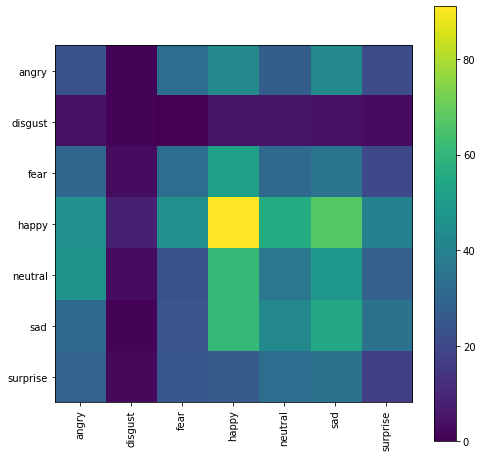

In [33]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 31s 85ms/step
Confusion Matrix
[[ 473   45  449  791  538  558  342]
 [  52    3   36   88   68   59   43]
 [ 474   56  401  798  552  622  375]
 [ 819   99  748 1396 1037 1066  607]
 [ 586   46  463 1048  710  688  431]
 [ 518   60  488 1000  694  698  406]
 [ 379   46  287  632  472  444  277]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.15      3196
     disgust       0.01      0.01      0.01       349
        fear       0.14      0.12      0.13      3278
       happy       0.24      0.24      0.24      5772
     neutral       0.17      0.18      0.18      3972
         sad       0.17      0.18      0.17      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



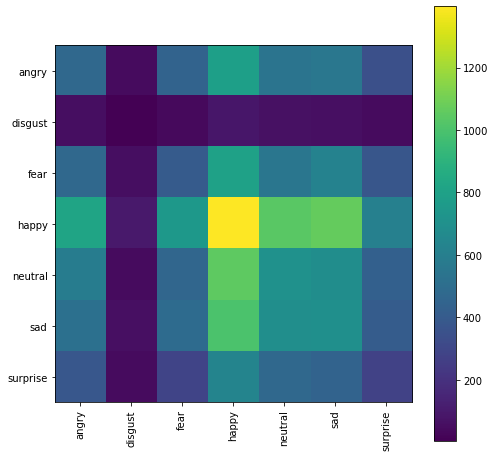

In [34]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

ROC AUC score: 0.9538596832589815


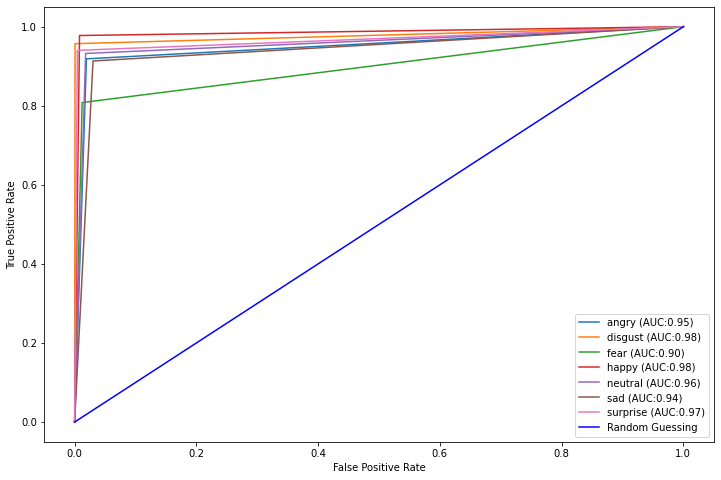

In [40]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['angry', 'disgust', 'fear', 'happy', 'neutral',
          'sad', 'surprise']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average,multi_class='ovo')


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.9538596832589815


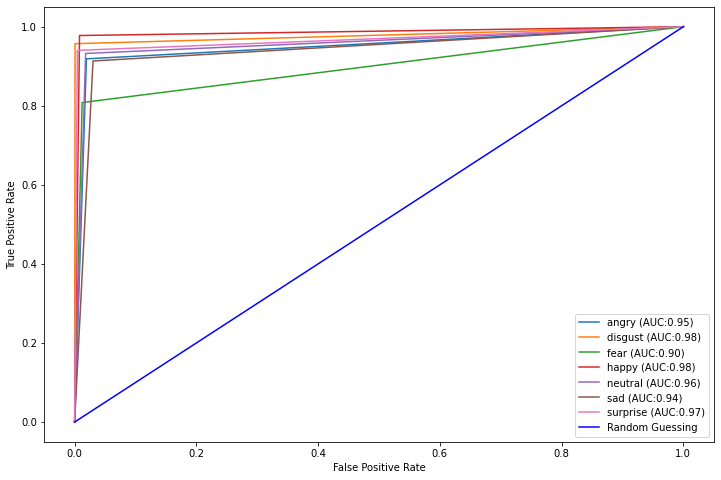

In [41]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['angry', 'disgust', 'fear', 'happy', 'neutral',
          'sad', 'surprise']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average,multi_class='ovr')


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

ROC AUC score: 0.7869914640979575


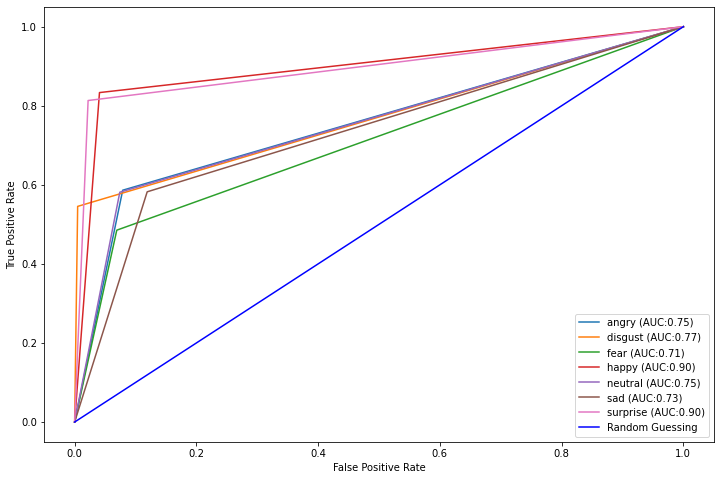

In [36]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred_test))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()